In [1]:
import numpy as np
import pandas as pd 
import struct
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential, regularizers
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(num, rows, cols, 1)  # Add channel dimension
        return images / 255.0  # Normalize pixel values

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [2]:
# let's load our data from different paths
x_train = load_images("/kaggle/input/mnist-dataset/train-images.idx3-ubyte")
y_train = load_labels('/kaggle/input/mnist-dataset/train-labels.idx1-ubyte')

x_test = load_images('/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte')
y_test = load_labels('/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte')

In [3]:
# Lets create the dataframe 
train_data={}
train_data['images'] = pd.Series(list(x_train))
train_data['labels'] = pd.Series(y_train)

train_df = pd.DataFrame(train_data)

In [4]:
# Lets see the number of images for each class
train_df.labels.value_counts()

labels
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

### Observations:

1.The most frequent class (1) has 6742 samples.

2.The least frequent class (5) has 5421 samples.

Difference: 6742 - 5421 = 1321, which is roughly a 20% variation.

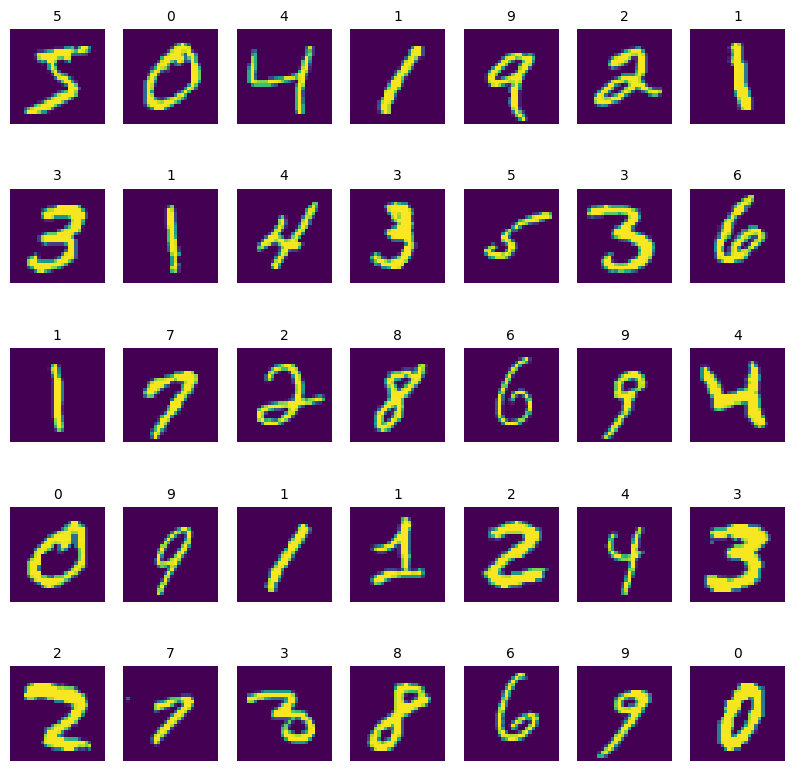

In [5]:
# Plotting the Images of different classes,
plt.figure(figsize=(10,10))
for i in range(35):
    plt.subplot(5,7,i+1)
    plt.imshow(train_df.images[i])
    plt.title(train_df.labels[i],size=10)
    plt.axis('off')

# 1st Approach ( Main Dataset )

In [6]:
model_1 = models.Sequential([
    #CNN Layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer= regularizers.l2(0.03)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer= regularizers.l2(0.03)),
    layers.BatchNormalization(),
    
    # ANN Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    layers.Dense(10, activation='softmax')
])

model_1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Defining EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Defining ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)
# Now we will train the model
history_1 = model_1.fit(np.stack(train_df.images), train_df.labels, epochs=40, 
                    validation_data=(x_test, y_test),callbacks=[early_stop, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8329 - loss: 2.5698 - val_accuracy: 0.9727 - val_loss: 0.5302 - learning_rate: 1.0000e-04
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9765 - loss: 0.3958 - val_accuracy: 0.9778 - val_loss: 0.1868 - learning_rate: 1.0000e-04
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9818 - loss: 0.1570 - val_accuracy: 0.9819 - val_loss: 0.1176 - learning_rate: 1.0000e-04
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9850 - loss: 0.1027 - val_accuracy: 0.9885 - val_loss: 0.0811 - learning_rate: 1.0000e-04
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9868 - loss: 0.0812 - val_accuracy: 0.9880 - val_loss: 0.0711 - learning_rate: 1.0000e-04
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9871 - loss: 0.0719 - val_accuracy: 0.9881 - val_loss: 0.0651 - learning_rate: 1.0000e-04
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

train : accuracy: 0.9972  ,  loss: 0.0233 

Validation : val_accuracy: 0.9918 , val_loss: 0.0346

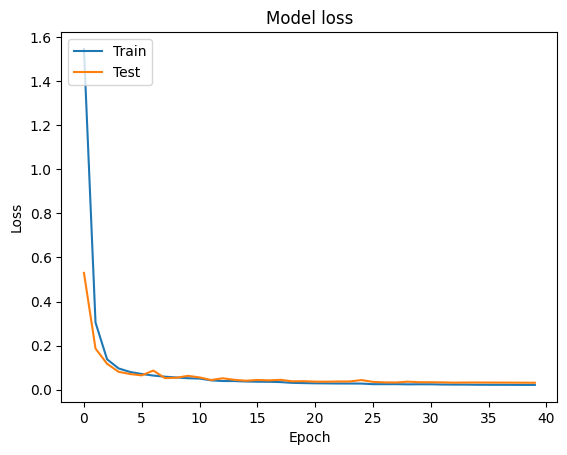

In [7]:
# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Now we will Create a Biased Dataset 

In [8]:
# Step 1: Find all indices where the label is 5 & 0 ,
indices_class_5 = np.where(y_train == 5)[0]
indices_class_0 = np.where(y_train == 0)[0]

np.random.seed(42)  
indices_to_delete_5 = np.random.choice(indices_class_5, size=2500, replace=False)  #500
indices_to_delete_0 = np.random.choice(indices_class_0, size=3500, replace=False)  #1500
# now we will merge the two indices
indices_to_delete = np.concatenate((indices_to_delete_5, indices_to_delete_0))

# Step 3: Delete those indices from x_train and y_train
x_train_biased = np.delete(x_train, indices_to_delete, axis=0)
y_train_biased = np.delete(y_train, indices_to_delete, axis=0)

In [9]:
# checking number of rows for each classes
pd.Series(y_train_biased).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
6    5918
8    5851
4    5842
5    2921
0    2423
Name: count, dtype: int64

### Now the dataset is a "biased dataset" 

# 2nd Approach (Biased dataset)
### * Basic Model using CNN and ANN

In [10]:

model_2 = Sequential()

# CNN Layers
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten + Ann Layers
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))

# Output Layer
model_2.add(Dense(10, activation='softmax'))

model_2.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history_2 = model_2.fit(x_train_biased ,y_train_biased, epochs=20,validation_split=(0.2))

Epoch 1/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8421 - loss: 0.4939 - val_accuracy: 0.9764 - val_loss: 0.0774
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9789 - loss: 0.0671 - val_accuracy: 0.9819 - val_loss: 0.0594
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9850 - loss: 0.0460 - val_accuracy: 0.9853 - val_loss: 0.0460
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9898 - loss: 0.0324 - val_accuracy: 0.9877 - val_loss: 0.0434
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 0.9853 - val_loss: 0.0483
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.9875 - val_loss: 0.0447
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9946 - loss: 0.0161 - val_accuracy: 0.9881 - val_loss: 0.0460
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9959 - loss: 0.0129 - 

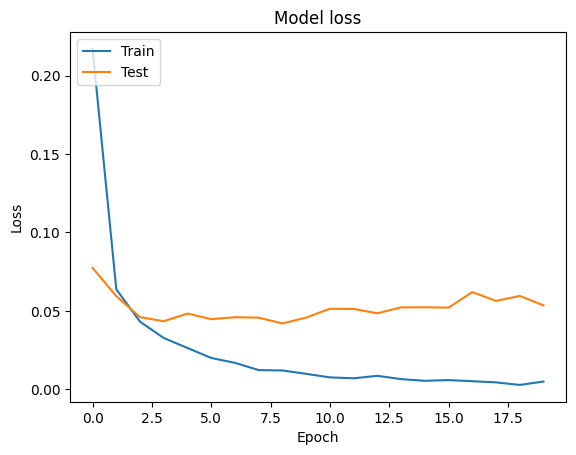

In [12]:
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
y_pred_2 = model_2.predict(x_test)
y_predicted_2 = [np.argmax(i) for i in y_pred_2]
y_predicted_2[0:10]
# Lets find the model's performance
print(classification_report(y_test, y_predicted_2))

print("-"*70)

print(f'Accuracy Score : {accuracy_score(y_test, y_predicted_2)}')
print(f'Precision Score : {precision_score(y_test, y_predicted_2, average="weighted")}')
print(f'Recall Score : {recall_score(y_test, y_predicted_2, average="weighted")}')
print(f'F1 Score : {f1_score(y_test, y_predicted_2, average="weighted")}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

----------------------------------------------------------------------
Accuracy Score : 0.9906
Precision Score : 0.990612291826364
Recall Score : 0.9906
F1 Score : 0.990601549381704


<Axes: >

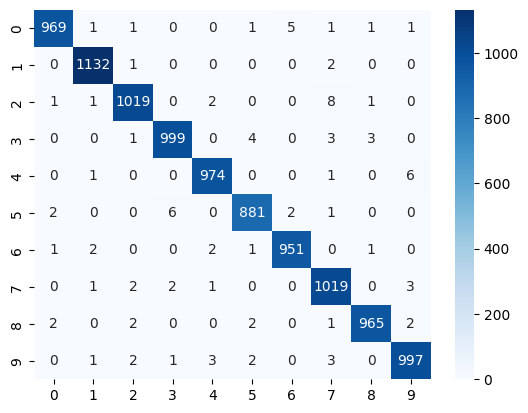

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


### Observations
1. Model has a 99.1% accuracy on the test data.
2. train and vaidation loss are not converging well.
3. Though its a biased datset, the F1 score is good for every class.

# 3rd Approach : (biased dataset) 
### Techniques used
1. early stopping
2. ReduceLROnPlateau
3. Reqularization

In [15]:
model_3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer= regularizers.l2(0.04)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer= regularizers.l2(0.04)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    layers.Dense(10, activation='softmax')
])

model_3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)

history_3 = model_3.fit(np.stack(x_train_biased) ,y_train_biased, epochs=40,validation_split=(0.2),callbacks=[early_stop, reduce_lr])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7864 - loss: 3.6335 - val_accuracy: 0.9691 - val_loss: 0.9222 - learning_rate: 1.0000e-04
Epoch 2/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9698 - loss: 0.7196 - val_accuracy: 0.9713 - val_loss: 0.3510 - learning_rate: 1.0000e-04
Epoch 3/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9772 - loss: 0.2773 - val_accuracy: 0.9797 - val_loss: 0.1750 - learning_rate: 1.0000e-04
Epoch 4/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9812 - loss: 0.1537 - val_accuracy: 0.9827 - val_loss: 0.1214 - learning_rate: 1.0000e-04
Epoch 5/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9839 - loss: 0.1109 - val_accuracy: 0.9472 - val_loss: 0.2051 - learning_rate: 1.0000e-04
Epoch 6/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9865 - loss: 0.0917 - val_accuracy: 0.9788 - val_loss: 0.1077 - learning_rate: 1.0000e-04
Epoch 7/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/ste

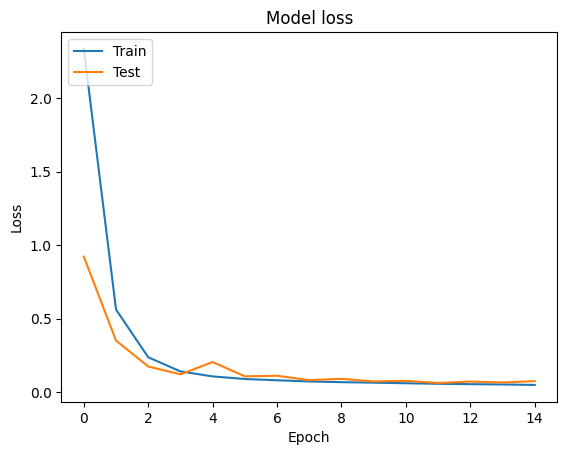

In [16]:
# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
y_pred_3 = model_3.predict(x_test)
y_predicted_3 = [np.argmax(i) for i in y_pred_3]
# Lets find the model's performance
print(classification_report(y_test, y_predicted_3))

print("-"*70)

print(f'Accuracy Score : {accuracy_score(y_test, y_predicted_3)}')
print(f'Precision Score : {precision_score(y_test, y_predicted_3, average="weighted")}')
print(f'Recall Score : {recall_score(y_test, y_predicted_3, average="weighted")}')
print(f'F1 Score : {f1_score(y_test, y_predicted_3, average="weighted")}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.96      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

----------------------------------------------------------------------
Accuracy Score : 0.9889
Precision Score : 0.9889440175919101
Recall Score : 0.9889
F1 Score : 0.9888843104637138


1. Model is still performing well for all classes.
2. Train and validation loss are converging well.

<Axes: >

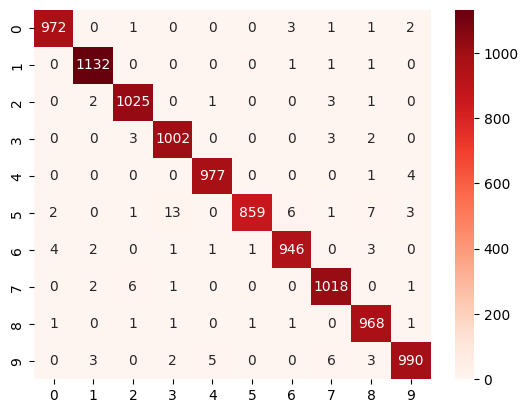

In [18]:
# confusion matrix 
cm = confusion_matrix(y_test, y_predicted_3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

# 4th Approach : (biased dataset) 
### Techniques used
1. class_weight Method
2. early stopping
3. ReduceLROnPlateau

In [19]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_biased),
    y=y_train_biased
)

class_weights_dict = {i: class_weights[i] for i in range(10)}
print("Class weights:", class_weights_dict)

Class weights: {0: 2.228642179116797, 1: 0.8009492732126965, 2: 0.9063444108761329, 3: 0.8807698580981895, 4: 0.9243409791167408, 5: 1.8486819582334817, 6: 0.9124704291990537, 7: 0.8619313647246608, 8: 0.9229191591180995, 9: 0.9077155824508321}


In [20]:
# creating our model with CNN and ANN Layers
model_4 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer= regularizers.l2(0.04)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer= regularizers.l2(0.04)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    layers.Dense(10, activation='softmax')
])

model_4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




# Adding early stopping and ReduceLROnPlateau 
early_stop = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)

history_4 = model_4.fit(np.stack(x_train_biased) ,y_train_biased, epochs=40,validation_split=(0.2),callbacks=[early_stop, reduce_lr],class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8004 - loss: 3.5789 - val_accuracy: 0.9679 - val_loss: 0.9195 - learning_rate: 1.0000e-04
Epoch 2/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9681 - loss: 0.7055 - val_accuracy: 0.9768 - val_loss: 0.3141 - learning_rate: 1.0000e-04
Epoch 3/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9768 - loss: 0.2653 - val_accuracy: 0.9754 - val_loss: 0.1798 - learning_rate: 1.0000e-04
Epoch 4/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9810 - loss: 0.1486 - val_accuracy: 0.9761 - val_loss: 0.1409 - learning_rate: 1.0000e-04
Epoch 5/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9841 - loss: 0.1065 - val_accuracy: 0.9860 - val_loss: 0.0908 - learning_rate: 1.0000e-04
Epoch 6/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9858 - loss: 0.0896 - val_accuracy: 0.9876 - val_loss: 0.0843 - learning_rate: 1.0000e-04
Epoch 7/40
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/ste

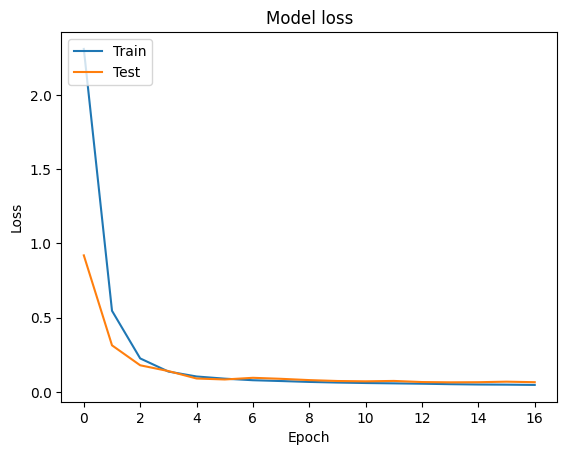

In [21]:
# Plot training & validation loss values
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
y_pred_4 = model_4.predict(x_test)
y_predicted_4 = [np.argmax(i) for i in y_pred_4]

# Lets find the classification report 
print(classification_report(y_test, y_predicted_4))

print("-"*70)

print(f'Accuracy Score : {accuracy_score(y_test, y_predicted_4)}')
print(f'Precision Score : {precision_score(y_test, y_predicted_4, average="weighted")}')
print(f'Recall Score : {recall_score(y_test, y_predicted_4, average="weighted")}')
print(f'F1 Score : {f1_score(y_test, y_predicted_4, average="weighted")}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

----------------------------------------------------------------------
Accuracy Score : 0.9882
Precision Score : 0.9882534416066366
Recall Score : 0.9882
F1 Score : 0.9881865939740055


<Axes: >

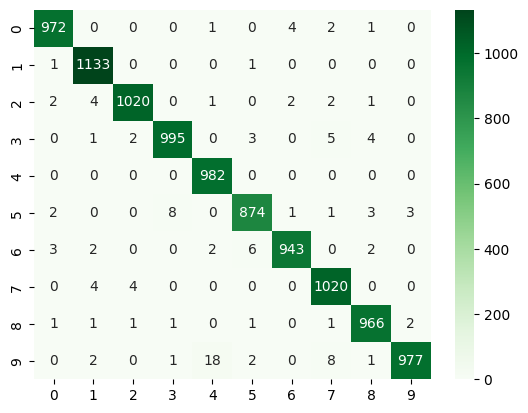

In [23]:
# confusion matrix 
cm = confusion_matrix(y_test, y_predicted_4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

### We can say our 4th model is performing well with the minority class 
### we can conclude that ,The final model (model_4) demonstrated superior performance compared to all previous models trained on the imbalanced MNIST dataset. By incorporating a combination of class weighting, convolutional layers, dropout, L2 regularization, batch normalization, and learning rate scheduling, the model was able to significantly mitigate the effects of class imbalance and improve generalization.